# LSTM 방법론을 활용한 시계열 데이터 예측

- - -
### 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, load_model
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils

from datetime import datetime, timedelta, timezone

### 데이터 불러오기

In [2]:
# data load

df4 = pd.read_csv('simul_sample4_full.csv', header = None)
df4.columns = ['date','value']
df4.index = df4["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df4 = df4.drop(['date'], axis=1)


df5 = pd.read_csv('simul_sample5_full.csv', header = None)
df5.columns = ['date','value']
df5.index = df5["date"].apply(func = lambda x: datetime.strptime(x, '%Y-%m-%d'))
df5 = df5.drop(['date'], axis=1)


df6 = pd.read_csv('simul_sample6_full.csv', header = None)
df6.columns = ['date','value']
df6.index = df6["date"].apply(func = lambda x: datetime.strptime(x, '%Y-%m-%d'))
df6 = df6.drop(['date'], axis=1)

### 데이터 시각화

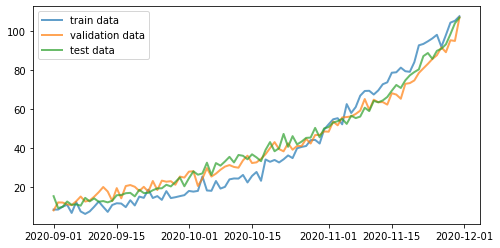

In [3]:
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams['lines.linewidth'] = 2

plt.plot(df4['value'], alpha = .7)
plt.plot(df5['value'], alpha = .7)
plt.plot(df6['value'], alpha = .7)

plt.legend(['train data','validation data','test data'])

### 훈련 데이터 시각화

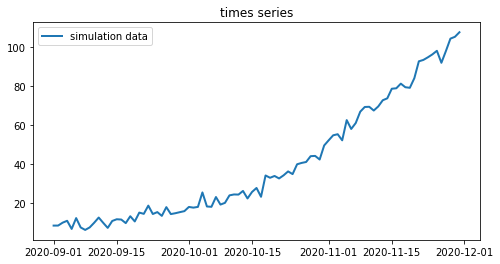

In [4]:
plt.title('times series')
plt.plot(df4['value'])

plt.legend(['simulation data'])

### 훈련 데이터 시계열 분해

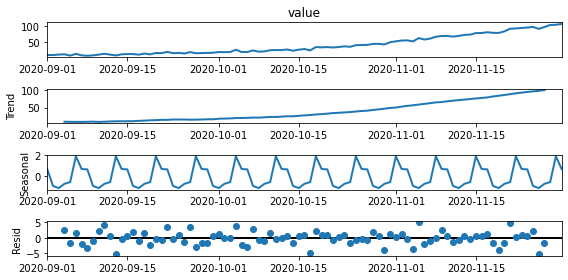

In [5]:
ts = df4.value

result = seasonal_decompose(ts, model = 'additive')

result.plot()
plt.show()

### 데이터 전처리(model1)

In [6]:
scaler_train = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_train = scaler_train.fit(df4)
scaled_train = scaler_train.transform(df4)

scaler_val = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_val = scaler_val.fit(df5)
scaled_val = scaler_val.transform(df5)

scaler_test = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_test = scaler_test.fit(df6)
scaled_test = scaler_test.transform(df6)


window_size= 7

n_rows_train = len(scaled_train)
n_rows_val = len(scaled_val)
n_rows_test = len(scaled_test)


features_train = []
labels_train = []

for i in range(window_size, n_rows_train):
    features_train.append(scaled_train[i-window_size:i])
    labels_train.append(scaled_train[i])

    
features_val = []
labels_val = []

for i in range(window_size, n_rows_val):
    features_val.append(scaled_val[i-window_size:i])
    labels_val.append(scaled_val[i])

    
features_test = []
labels_test = []

for i in range(window_size, n_rows_test):
    features_test.append(scaled_test[i-window_size:i])
    labels_test.append(scaled_test[i])

    
    
features_train, labels_train = np.array(features_train), np.array(labels_train)
features_val, labels_val = np.array(features_val), np.array(labels_val)
features_test, labels_test = np.array(features_test), np.array(labels_test)

features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[1], 1))
features_val = np.reshape(features_val, (features_val.shape[0], features_val.shape[1], 1))
features_test = np.reshape(features_test, (features_test.shape[0], features_test.shape[1], 1))

### 예측 모델 옵션 설정

In [7]:
#랜덤 시드 설정
np.random.seed(100)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

### 예측 모델 구축

In [8]:
# 배치 사이즈
batch_size = 1

# model 4
model = Sequential()

## layer 1
model.add(LSTM(units = 100,
                batch_input_shape = (batch_size, features_train.shape[1], 1),
                return_sequences = False,
                stateful = True,
                activation = 'tanh'))

## Dense
model.add(Dense(units = 1,
                 activation = 'tanh'))

model._name = 'model'

## compile
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ["mse","mae",'mape'])


### 예측 모델 훈련하기

In [9]:
# 손실 이력 객체 생성
history = LossHistory()
history.init()

num_epochs = 100

for epoch_idx in range(1,num_epochs+1):
    print ('\nEpochs : ' + str(epoch_idx) )
    model.fit(features_train,
               labels_train,
               validation_data = (features_val, labels_val),
               epochs = 1,
               batch_size = batch_size,
               verbose = 1,
               shuffle = False,
               callbacks = [history])
    
    if epoch_idx > 1 and history.val_losses[epoch_idx-1] < np.min(history.val_losses[:epoch_idx-1]):
        model.save(filepath = 'LSTM_single_stateful_period7_model.h5')
        print('-> val_loss improved from {0:.4f}'.format(np.min(history.val_losses[:epoch_idx-1])),'to {0:.4f}, saving model to LSTM_single_stateful_period7_model.h5'.format(history.val_losses[epoch_idx-1]))
    else:
        print('-> val_loss did not improve from {0:.4f}'.format(np.min(history.val_losses)))
    
    model.reset_states()


Epochs : 1
84/84 [==============================] - 1s 8ms/step - loss: 0.0807 - mse: 0.0807 - mae: 0.2172 - mape: 52.5563 - val_loss: 0.2419 - val_mse: 0.2419 - val_mae: 0.4775 - val_mape: 16774.3652
-> val_loss did not improve from 0.2419

Epochs : 2
84/84 [==============================] - 0s 3ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1650 - mape: 38.5023 - val_loss: 0.1391 - val_mse: 0.1391 - val_mae: 0.2783 - val_mape: 2128.6030
-> val_loss improved from 0.2419 to 0.1391, saving model to LSTM_single_stateful_period7_model.h5

Epochs : 3
84/84 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - mae: 0.1451 - mape: 36.7806 - val_loss: 0.0317 - val_mse: 0.0317 - val_mae: 0.1453 - val_mape: 1267.8499
-> val_loss improved from 0.1391 to 0.0317, saving model to LSTM_single_stateful_period7_model.h5

Epochs : 4
84/84 [==============================] - 0s 3ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1246 - mape: 33.7607 - val_loss: 0.0321 - val_mse: 0.0321

-> val_loss did not improve from 0.0077

Epochs : 33
84/84 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0738 - mape: 23.2152 - val_loss: 0.0130 - val_mse: 0.0130 - val_mae: 0.0795 - val_mape: 1112.2256
-> val_loss did not improve from 0.0077

Epochs : 34
84/84 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0749 - mape: 23.2083 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0879 - val_mape: 865.4323
-> val_loss did not improve from 0.0077

Epochs : 35
84/84 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0770 - mape: 22.8895 - val_loss: 0.0106 - val_mse: 0.0106 - val_mae: 0.0852 - val_mape: 2687.1216
-> val_loss did not improve from 0.0077

Epochs : 36
84/84 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0752 - mape: 26.5079 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0590 - val_mape: 295.5293
-> val_loss improved from 0.0077 t

84/84 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0528 - mape: 15.7272 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0538 - val_mape: 1290.9026
-> val_loss improved from 0.0050 to 0.0048, saving model to LSTM_single_stateful_period7_model.h5

Epochs : 66
84/84 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0524 - mape: 16.9163 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0582 - val_mape: 1928.1135
-> val_loss did not improve from 0.0048

Epochs : 67
84/84 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0518 - mape: 15.7218 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0517 - val_mape: 1022.4528
-> val_loss improved from 0.0048 to 0.0044, saving model to LSTM_single_stateful_period7_model.h5

Epochs : 68
84/84 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0515 - mape: 16.4491 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae

84/84 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0673 - mape: 26.6962 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0607 - val_mape: 1633.7247
-> val_loss did not improve from 0.0041

Epochs : 99
84/84 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0597 - mape: 21.8547 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0832 - val_mape: 2542.8267
-> val_loss did not improve from 0.0041

Epochs : 100
84/84 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0628 - mape: 22.5318 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0537 - val_mape: 516.7088
-> val_loss did not improve from 0.0041


### 예측 모델 요약정보

In [10]:
model = load_model(filepath = 'LSTM_single_stateful_period7_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 100)                  40800     
_________________________________________________________________
dense (Dense)                (1, 1)                    101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


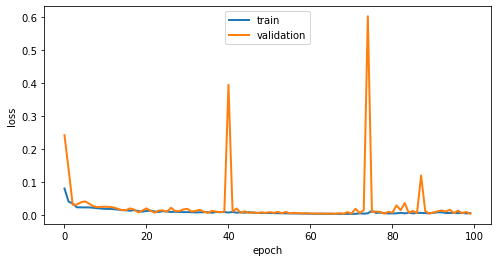

In [11]:
# 6. 학습과정 살펴보기

plt.plot(history.losses)
plt.plot(history.val_losses)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper center')
plt.show()

### 예측 모델 평가하기(MSE, MAE, MAPE)

In [12]:
# 7. 모델 평가하기
print('훈련 데이터로 평가하기')
scores = model.evaluate(features_train, labels_train, batch_size = batch_size, verbose = 0)
print()
print('train - MSE :', np.round(scores[1], 4))
print('train - RMSE :', np.round(np.sqrt(scores[1]), 4))
print('train - MAE:', np.round(scores[2], 4))
print('train - MAPE:', np.round(scores[3], 4))
model.reset_states()
print()

print('밸리데이션 데이터로 평가하기')
scores = model.evaluate(features_val, labels_val, batch_size=batch_size, verbose = 0)
print()
print('val - MSE :', np.round(scores[1], 4))
print('val - RMSE :', np.round(np.sqrt(scores[1]), 4))
print('val - MAE:', np.round(scores[2], 4))
print('val - MAPE:', np.round(scores[3], 4))
model.reset_states()

훈련 데이터로 평가하기

train - MSE : 0.0045
train - RMSE : 0.0668
train - MAE: 0.0557
train - MAPE: 17.5354

밸리데이션 데이터로 평가하기

val - MSE : 0.0037
val - RMSE : 0.0604
val - MAE: 0.0483
val - MAPE: 460.2785


### 훈련된 모델로 예측하기

In [17]:
seq_in = scaled_test[:window_size]

pred_val = []
lb_pred_val = []
ub_pred_val = []

prediction_period = len(df6.index)-window_size

for i in range(prediction_period):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(seq_in, (seq_in.shape[1], seq_in.shape[0], 1)) # 샘플 수, 타임스텝 수, 속성 수
    
    pred_out = model.predict(sample_in)
       
    seq_in = np.append(seq_in, pred_out, axis = 0)
    seq_in = np.delete(seq_in, [0], axis = 0)
    
    pred = scaler_test.inverse_transform(pred_out)
    pred = pred[0][0]
    
    pred_val.append(pred)
    
    predict_range = 1.96*np.sqrt(np.min(history.losses)*(1+1/prediction_period+i))

    lb_val = pred - predict_range
    lb_pred_val.append(lb_val)
    
    ub_val = pred + predict_range
    ub_pred_val.append(ub_val)
    
    print(i+1, '/', prediction_period, 'days')
    
model.reset_states()
    
model_pred_df = pd.DataFrame({'pred_value':pred_val,
                        'lb_value':lb_pred_val,
                        'ub_value':ub_pred_val},
                        index = pd.date_range(end = df6.index[-1], periods = prediction_period, freq='D'))

1 / 84 days
2 / 84 days
3 / 84 days
4 / 84 days
5 / 84 days
6 / 84 days
7 / 84 days
8 / 84 days
9 / 84 days
10 / 84 days
11 / 84 days
12 / 84 days
13 / 84 days
14 / 84 days
15 / 84 days
16 / 84 days
17 / 84 days
18 / 84 days
19 / 84 days
20 / 84 days
21 / 84 days
22 / 84 days
23 / 84 days
24 / 84 days
25 / 84 days
26 / 84 days
27 / 84 days
28 / 84 days
29 / 84 days
30 / 84 days
31 / 84 days
32 / 84 days
33 / 84 days
34 / 84 days
35 / 84 days
36 / 84 days
37 / 84 days
38 / 84 days
39 / 84 days
40 / 84 days
41 / 84 days
42 / 84 days
43 / 84 days
44 / 84 days
45 / 84 days
46 / 84 days
47 / 84 days
48 / 84 days
49 / 84 days
50 / 84 days
51 / 84 days
52 / 84 days
53 / 84 days
54 / 84 days
55 / 84 days
56 / 84 days
57 / 84 days
58 / 84 days
59 / 84 days
60 / 84 days
61 / 84 days
62 / 84 days
63 / 84 days
64 / 84 days
65 / 84 days
66 / 84 days
67 / 84 days
68 / 84 days
69 / 84 days
70 / 84 days
71 / 84 days
72 / 84 days
73 / 84 days
74 / 84 days
75 / 84 days
76 / 84 days
77 / 84 days
78 / 84 

### 예측 데이터로 평가


In [18]:
pred_val = pd.DataFrame(pred_val)
pred_val.columns = ['value']
pred_val.index = pd.date_range(end = df6.index[-1], periods = prediction_period, freq='D')

scaler_pred = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_pred = scaler_pred.fit(pred_val)
scaled_pred = scaler_pred.transform(pred_val)


n_rows_pred = len(scaled_pred)


features_pred = []
labels_pred = []

for i in range(window_size, n_rows_pred):
    features_pred.append(scaled_pred[i-window_size:i])
    labels_pred.append(scaled_pred[i])

    
features_pred, labels_pred = np.array(features_pred), np.array(labels_pred)
features_pred = np.reshape(features_pred, (features_pred.shape[0], features_pred.shape[1], 1))



print('예측 데이터로 평가하기')
scores = model.evaluate(features_pred, labels_pred, batch_size = batch_size, verbose = 0)
print()
print('pred - MSE :', np.round(scores[1], 4))
print('pred - RMSE :', np.round(np.sqrt(scores[1]), 4))
print('pred - MAE:', np.round(scores[2], 4))
print('pred - MAPE:', np.round(scores[3], 4))
model.reset_states()

예측 데이터로 평가하기

pred - MSE : 0.0005
pred - RMSE : 0.0225
pred - MAE: 0.0107
pred - MAPE: 2.5437


### 예측 결과를 시각화

Text(0.5, 1.0, 'Prediction result [model]\n(time step= 7, layers= 1, stateful= True)')

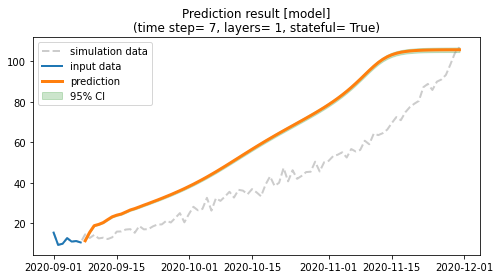

In [19]:
plt.plot(df6, color = 'grey', alpha = 0.4, linestyle = 'dashed')
plt.plot(df6[:window_size])
plt.plot(model_pred_df['pred_value'], lw = 3)
plt.fill_between(x = model_pred_df.index, y1 = model_pred_df['lb_value'], y2 = model_pred_df['ub_value'], alpha = 0.2, color = 'green')


plt.legend(['simulation data','input data','prediction','95% CI'], loc = 0)
plt.title('Prediction result [model]\n(time step= 7, layers= 1, stateful= True)')